## 1. Install Dependencies

Install required packages if needed:

In [1]:
# Uncomment to install
# !pip install torch opencv-python matplotlib huggingface_hub tqdm

## 2. Import Libraries

In [2]:
import os
import sys
import cv2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from pathlib import Path
from huggingface_hub import hf_hub_download
from tqdm.auto import tqdm
import random

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.1
CUDA available: False


/opt/miniconda3/envs/automl_sandbox/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Define U-Net Model

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        self.enc1 = DoubleConv(in_channels, 32)
        self.enc2 = DoubleConv(32, 64)
        self.enc3 = DoubleConv(64, 128)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(128, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = DoubleConv(256, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv(128, 64)

        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv(64, 32)

        self.final = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        b = self.bottleneck(self.pool(e3))

        d3 = self.up3(b)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.final(d1)

print("✅ U-Net model defined")

✅ U-Net model defined


## 4. Configuration

In [10]:
CONFIG = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'img_size': 256,
    'threshold': 0.5,
    
    # Paths (adjust for your setup)
    'images_dir': './Images',
    'model_cache': './models_cache',
}

print("Configuration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration:
  device: cpu
  img_size: 256
  threshold: 0.5
  images_dir: ./Images
  model_cache: ./models_cache


## 5. Download Pretrained Model

In [5]:
print("📥 Downloading pretrained U-Net model...")

model_path = hf_hub_download(
    repo_id="binhpdt/unet_fire_segmentation",
    filename="unet_best.pth",
    cache_dir=CONFIG['model_cache']
)

print(f"✅ Model downloaded to: {model_path}")
print(f"   Size: {os.path.getsize(model_path) / 1024 / 1024:.2f} MB")

📥 Downloading pretrained U-Net model...
✅ Model downloaded to: ./models_cache/models--binhpdt--unet_fire_segmentation/snapshots/c46f66af2e0c2dd2552ec1f9dde6cc97dd9827f1/unet_best.pth
   Size: 7.40 MB


## 6. Load Model

In [6]:
device = torch.device(CONFIG['device'])
print(f"🔥 Using device: {device}")

# Initialize and load model
model = UNet(in_channels=3, out_channels=1)
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model.to(device)
model.eval()

print("✅ Model loaded successfully!")

# Count parameters
n_params = sum(p.numel() for p in model.parameters())
print(f"   Parameters: {n_params:,}")
print(f"   Model size: ~{n_params * 4 / 1024 / 1024:.1f} MB")

🔥 Using device: cpu
✅ Model loaded successfully!
   Parameters: 1,928,417
   Model size: ~7.4 MB


## 7. Helper Functions

In [7]:
def preprocess_image(image_path, img_size=256):
    """Load and preprocess image"""
    image = cv2.imread(str(image_path))
    if image is None:
        raise ValueError(f"Cannot read image: {image_path}")
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_h, original_w = image.shape[:2]
    
    image_resized = cv2.resize(image, (img_size, img_size))
    image_normalized = image_resized.astype(np.float32) / 255.0
    
    image_tensor = torch.from_numpy(image_normalized).permute(2, 0, 1).unsqueeze(0)
    
    return image, image_tensor, (original_h, original_w)


def predict(model, image_path, threshold=0.5, device='cpu'):
    """Predict fire segmentation mask"""
    original_image, image_tensor, (orig_h, orig_w) = preprocess_image(image_path)
    image_tensor = image_tensor.to(device)
    
    with torch.no_grad():
        output = model(image_tensor)
        pred_prob = torch.sigmoid(output).squeeze().cpu().numpy()
    
    pred_mask_small = (pred_prob > threshold).astype(np.uint8)
    pred_mask = cv2.resize(
        pred_mask_small,
        (orig_w, orig_h),
        interpolation=cv2.INTER_NEAREST
    )
    
    fire_pixels = pred_mask.sum()
    total_pixels = pred_mask.size
    fire_percentage = (fire_pixels / total_pixels) * 100
    confidence = pred_prob.mean()
    
    return {
        'original_image': original_image,
        'pred_mask': pred_mask,
        'fire_percentage': fire_percentage,
        'confidence': float(confidence)
    }


def visualize_prediction(result, title=""):
    """Visualize prediction results"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    original = result['original_image']
    mask = result['pred_mask']
    fire_pct = result['fire_percentage']
    confidence = result['confidence']
    
    # Original
    axes[0].imshow(original)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Mask
    axes[1].imshow(mask * 255, cmap='hot')
    axes[1].set_title(f'Fire Mask\n({fire_pct:.2f}% fire)')
    axes[1].axis('off')
    
    # Overlay
    overlay = original.copy()
    overlay[mask > 0] = [255, 0, 0]
    overlay = cv2.addWeighted(original, 0.6, overlay, 0.4, 0)
    axes[2].imshow(overlay)
    axes[2].set_title(f'Overlay\n(conf: {confidence:.3f})')
    axes[2].axis('off')
    
    if title:
        fig.suptitle(title, fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

print("✅ Helper functions defined")

✅ Helper functions defined


## 8. Load Test Images

In [11]:
images_dir = Path(CONFIG['images_dir'])
image_files = sorted(list(images_dir.glob('*.jpg')) + list(images_dir.glob('*.png')))

print(f"📂 Found {len(image_files)} images in {images_dir}")
if len(image_files) > 0:
    print(f"\nSample images:")
    for i, img in enumerate(image_files[:5]):
        print(f"  {i+1}. {img.name}")

📂 Found 2003 images in Images

Sample images:
  1. image_0.jpg
  2. image_1.jpg
  3. image_10.jpg
  4. image_100.jpg
  5. image_1000.jpg


## 9. Test on Single Random Image

Testing on: image_1085.jpg

📊 Results:
  Fire percentage: 0.34%
  Confidence: 0.003



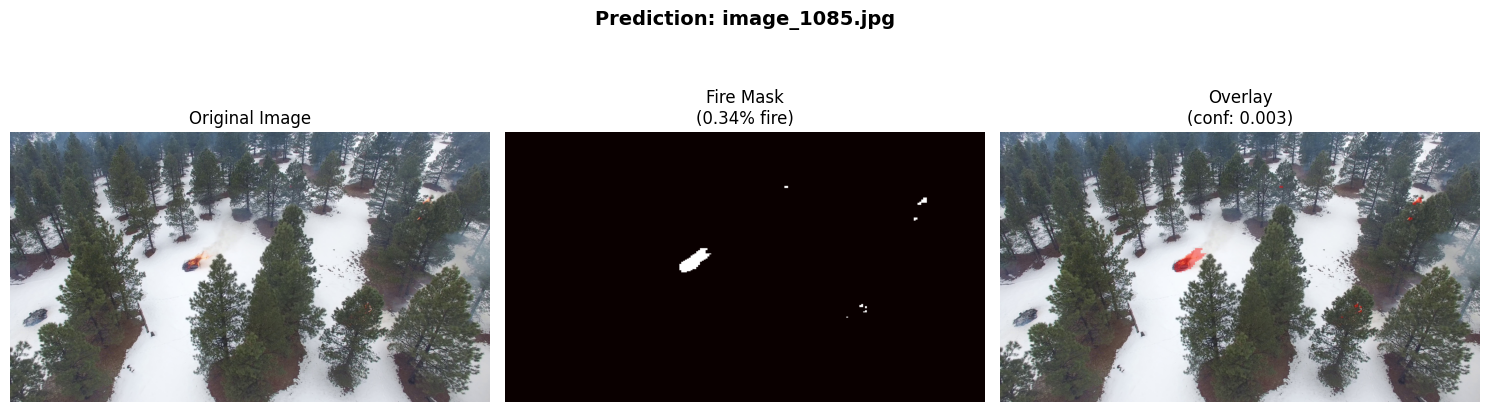

In [12]:
# Pick a random image
test_image = random.choice(image_files)
print(f"Testing on: {test_image.name}\n")

# Predict
result = predict(model, test_image, threshold=CONFIG['threshold'], device=device)

# Display metrics
print(f"📊 Results:")
print(f"  Fire percentage: {result['fire_percentage']:.2f}%")
print(f"  Confidence: {result['confidence']:.3f}")
print()

# Visualize
visualize_prediction(result, title=f"Prediction: {test_image.name}")

## 10. Test on Specific Image

Choose a specific image by index:

Testing on: image_0.jpg

📊 Results:
  Fire percentage: 0.41%
  Confidence: 0.004



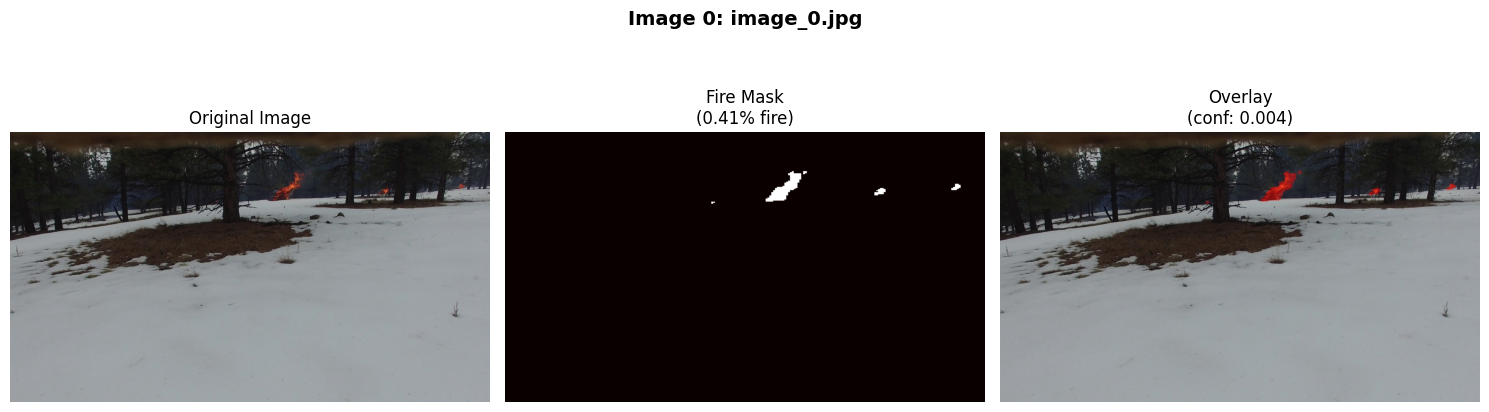

In [13]:
# Change this index to test different images
IMAGE_INDEX = 0  # Change to 0, 1, 2, etc.

if IMAGE_INDEX < len(image_files):
    test_image = image_files[IMAGE_INDEX]
    print(f"Testing on: {test_image.name}\n")
    
    result = predict(model, test_image, threshold=CONFIG['threshold'], device=device)
    
    print(f"📊 Results:")
    print(f"  Fire percentage: {result['fire_percentage']:.2f}%")
    print(f"  Confidence: {result['confidence']:.3f}")
    print()
    
    visualize_prediction(result, title=f"Image {IMAGE_INDEX}: {test_image.name}")
else:
    print(f"❌ Image index {IMAGE_INDEX} out of range (max: {len(image_files)-1})")

## 11. Test on Multiple Random Samples

🔥 Testing on 5 random images...


Sample 1/5: image_783.jpg
Fire: 0.70%, Confidence: 0.007


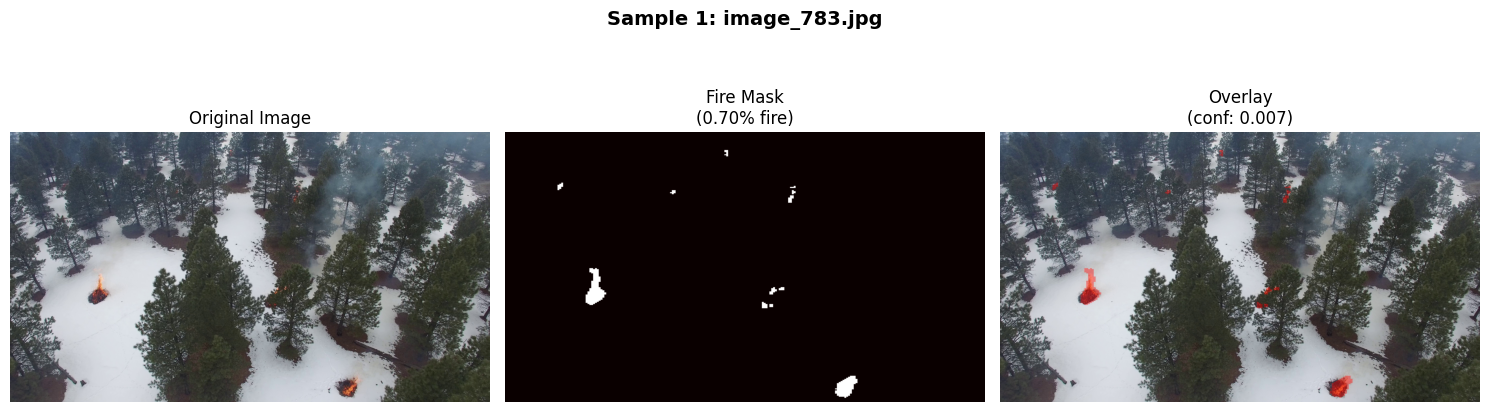


Sample 2/5: image_214.jpg
Fire: 0.60%, Confidence: 0.006


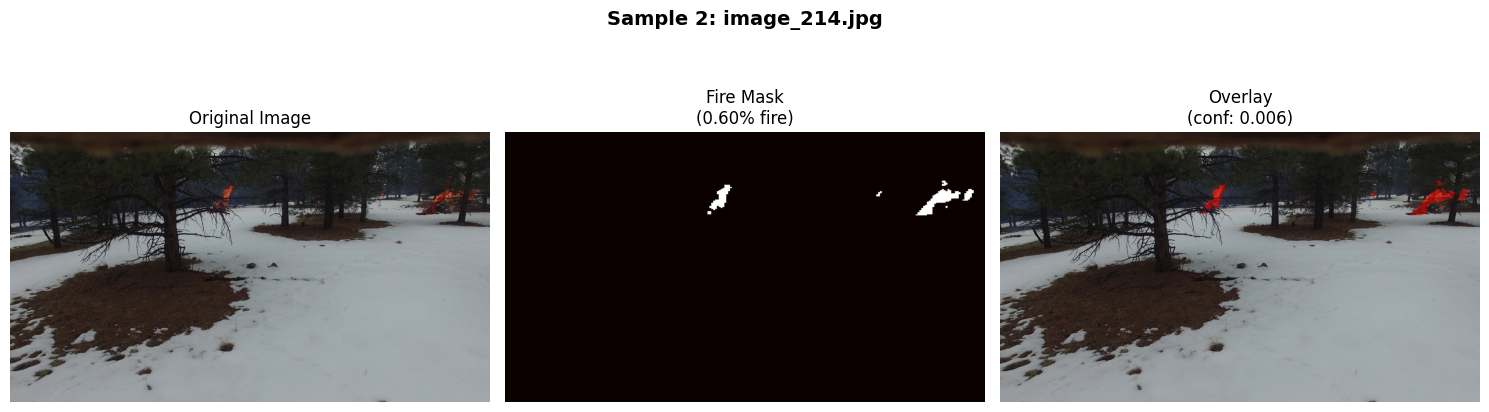


Sample 3/5: image_1254.jpg
Fire: 1.22%, Confidence: 0.012


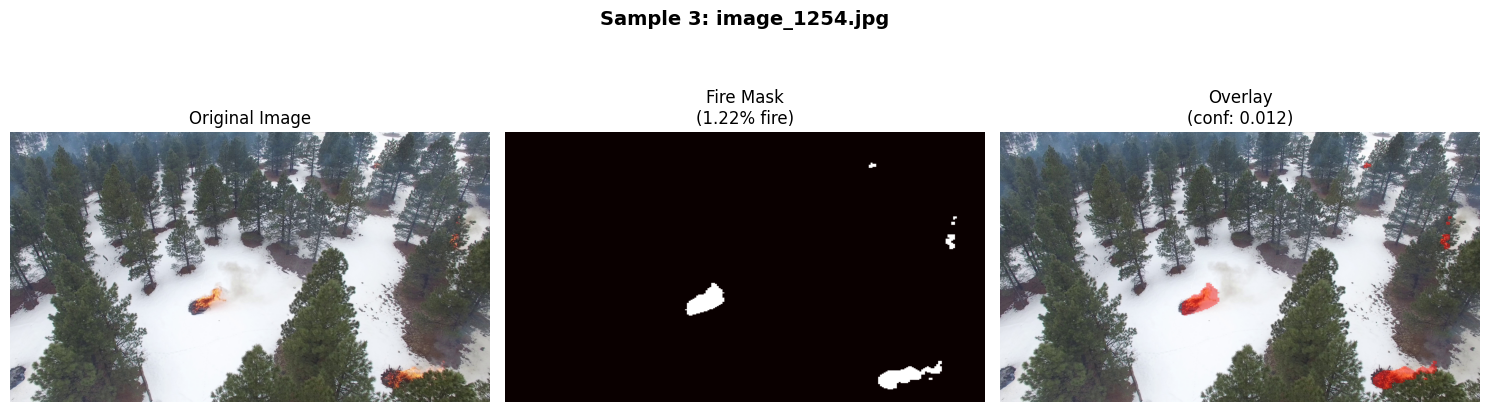


Sample 4/5: image_472.jpg
Fire: 0.01%, Confidence: 0.000


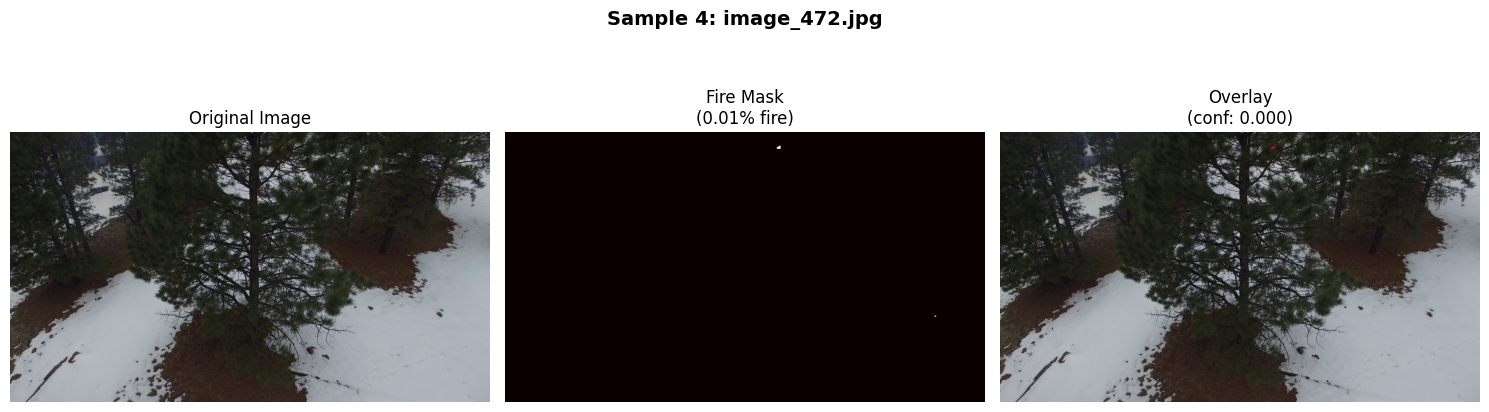


Sample 5/5: image_504.jpg
Fire: 0.50%, Confidence: 0.005


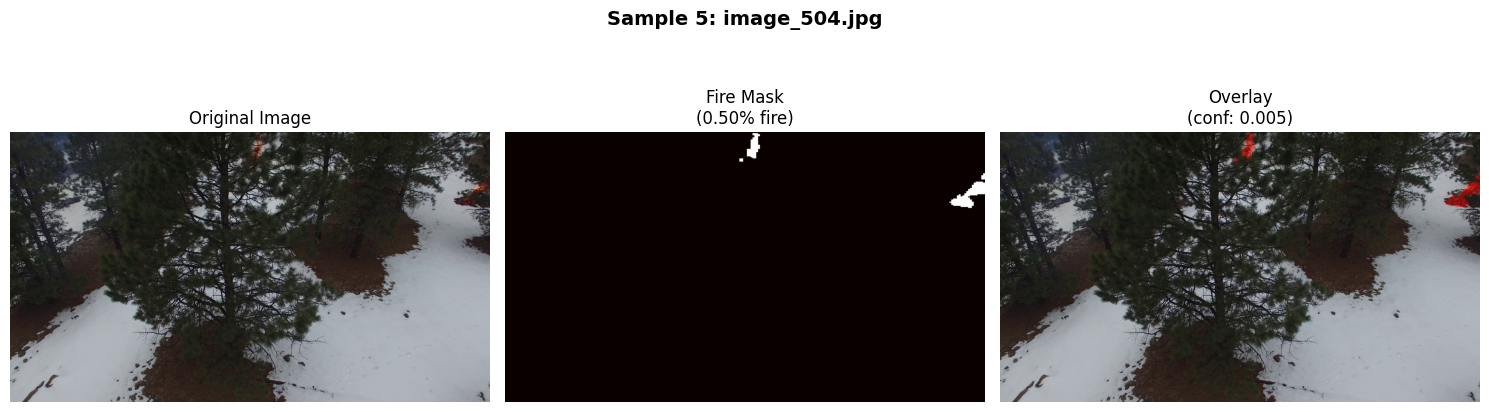

In [14]:
NUM_SAMPLES = 5  # Change this to test more or fewer images

print(f"🔥 Testing on {NUM_SAMPLES} random images...\n")

sample_images = random.sample(image_files, min(NUM_SAMPLES, len(image_files)))

for i, img_path in enumerate(sample_images, 1):
    print(f"\n{'='*60}")
    print(f"Sample {i}/{NUM_SAMPLES}: {img_path.name}")
    print('='*60)
    
    result = predict(model, img_path, threshold=CONFIG['threshold'], device=device)
    
    print(f"Fire: {result['fire_percentage']:.2f}%, Confidence: {result['confidence']:.3f}")
    
    visualize_prediction(result, title=f"Sample {i}: {img_path.name}")

## 12. Batch Analysis

Analyze all images and show statistics:

📊 Analyzing up to 20 images...



Processing: 100%|██████████| 20/20 [00:01<00:00, 10.27it/s]



BATCH ANALYSIS SUMMARY
Images processed: 20

Fire Coverage:
  Average: 0.33%
  Median:  0.33%
  Min:     0.27%
  Max:     0.42%
  Std:     0.04%

Confidence:
  Average: 0.003

Images with fire (>5%): 0
Images with fire (>10%): 0


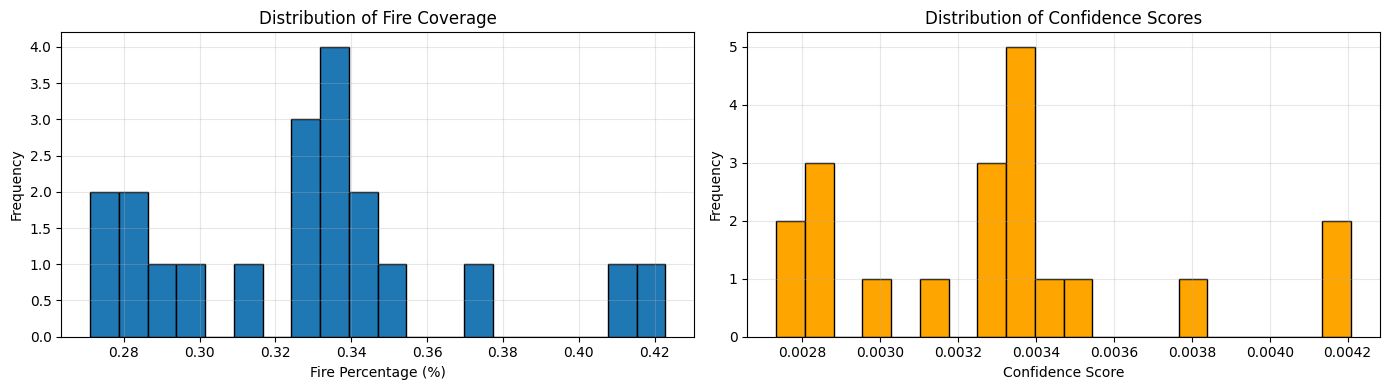


Top 5 images with most fire:
  1. image_1.jpg: 0.42%
  2. image_0.jpg: 0.41%
  3. image_10.jpg: 0.38%
  4. image_101.jpg: 0.35%
  5. image_100.jpg: 0.34%


In [15]:
MAX_IMAGES = 20  # Limit for faster processing

print(f"📊 Analyzing up to {MAX_IMAGES} images...\n")

results = []
test_images = image_files[:MAX_IMAGES]

for img_path in tqdm(test_images, desc="Processing"):
    try:
        result = predict(model, img_path, threshold=CONFIG['threshold'], device=device)
        results.append({
            'filename': img_path.name,
            'fire_percentage': result['fire_percentage'],
            'confidence': result['confidence']
        })
    except Exception as e:
        print(f"Error on {img_path.name}: {e}")

# Statistics
if results:
    fire_percentages = [r['fire_percentage'] for r in results]
    confidences = [r['confidence'] for r in results]
    
    print("\n" + "="*60)
    print("BATCH ANALYSIS SUMMARY")
    print("="*60)
    print(f"Images processed: {len(results)}")
    print(f"\nFire Coverage:")
    print(f"  Average: {np.mean(fire_percentages):.2f}%")
    print(f"  Median:  {np.median(fire_percentages):.2f}%")
    print(f"  Min:     {np.min(fire_percentages):.2f}%")
    print(f"  Max:     {np.max(fire_percentages):.2f}%")
    print(f"  Std:     {np.std(fire_percentages):.2f}%")
    print(f"\nConfidence:")
    print(f"  Average: {np.mean(confidences):.3f}")
    print(f"\nImages with fire (>5%): {sum(1 for p in fire_percentages if p > 5)}")
    print(f"Images with fire (>10%): {sum(1 for p in fire_percentages if p > 10)}")
    print("="*60)
    
    # Plot distribution
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    axes[0].hist(fire_percentages, bins=20, edgecolor='black')
    axes[0].set_xlabel('Fire Percentage (%)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Fire Coverage')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].hist(confidences, bins=20, edgecolor='black', color='orange')
    axes[1].set_xlabel('Confidence Score')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Distribution of Confidence Scores')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Top 5 images with most fire
    top_fire = sorted(results, key=lambda x: x['fire_percentage'], reverse=True)[:5]
    print("\nTop 5 images with most fire:")
    for i, r in enumerate(top_fire, 1):
        print(f"  {i}. {r['filename']}: {r['fire_percentage']:.2f}%")

## 13. Interactive Testing

Test with different thresholds:

Testing thresholds on: image_583.jpg



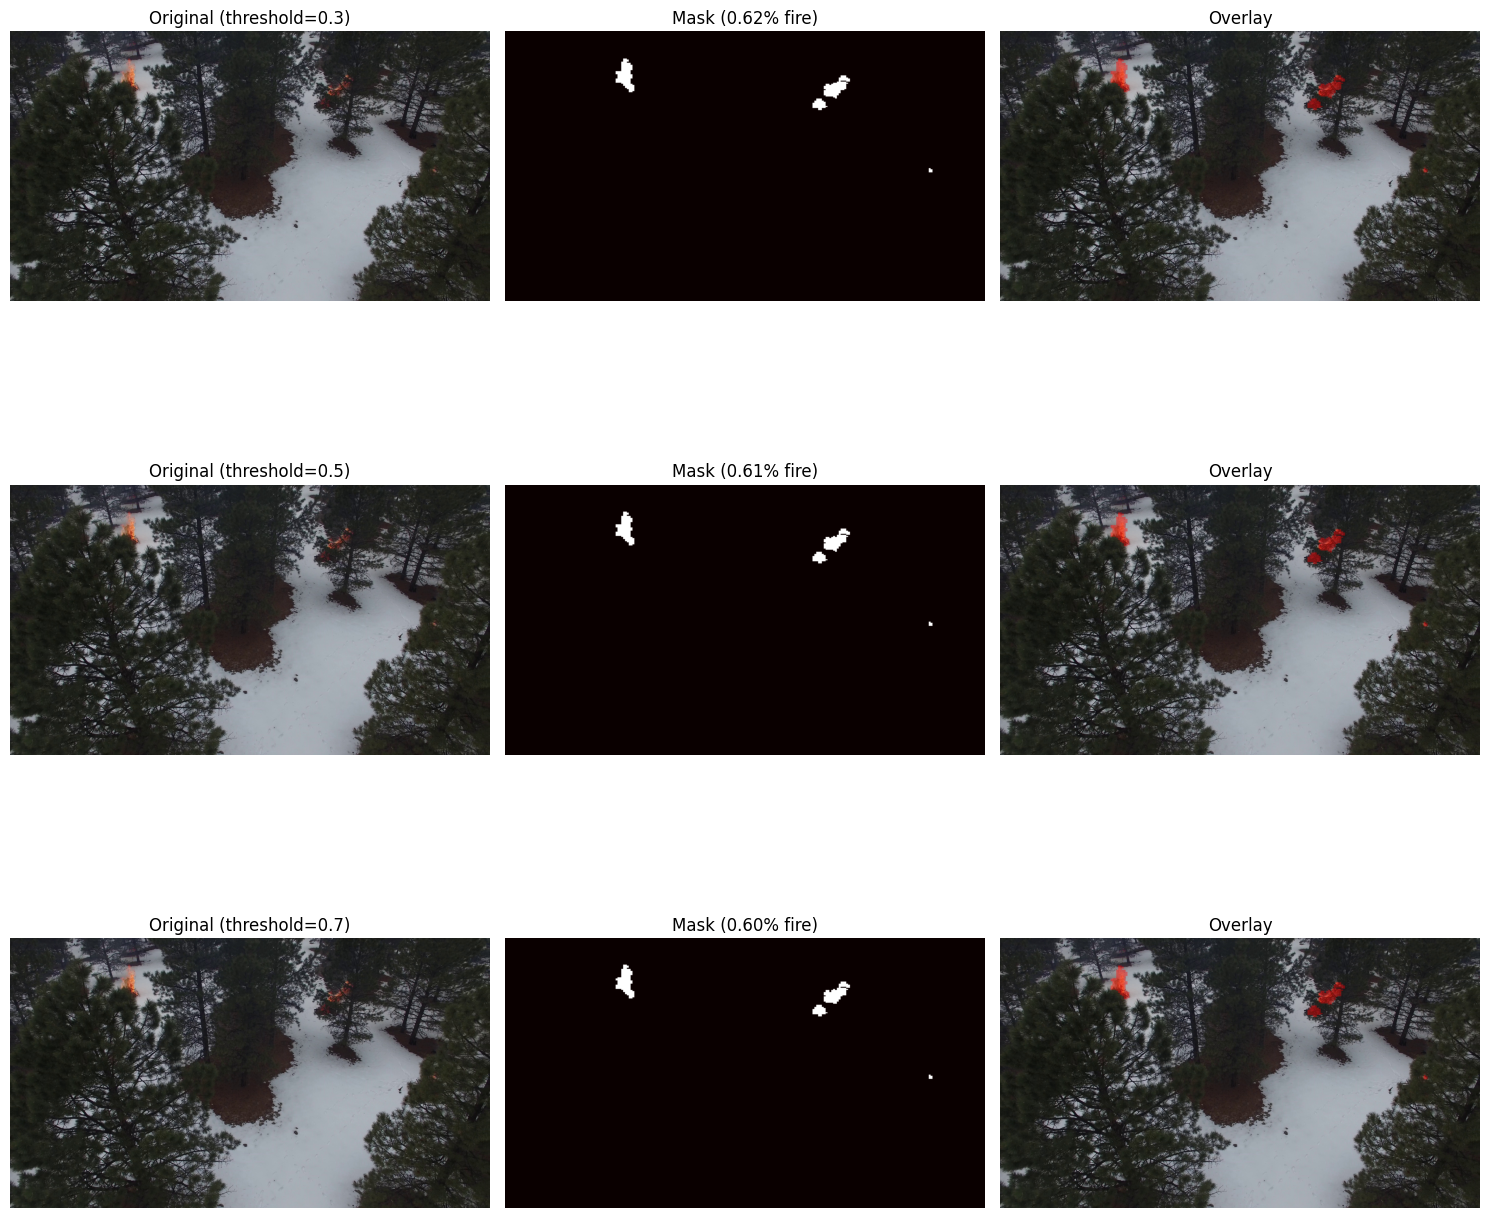

In [16]:
# Pick an image
test_image = random.choice(image_files)
print(f"Testing thresholds on: {test_image.name}\n")

# Test different thresholds
thresholds = [0.3, 0.5, 0.7]

fig, axes = plt.subplots(len(thresholds), 3, figsize=(15, 5*len(thresholds)))

for i, threshold in enumerate(thresholds):
    result = predict(model, test_image, threshold=threshold, device=device)
    
    original = result['original_image']
    mask = result['pred_mask']
    fire_pct = result['fire_percentage']
    
    # Original
    axes[i, 0].imshow(original)
    axes[i, 0].set_title(f'Original (threshold={threshold})')
    axes[i, 0].axis('off')
    
    # Mask
    axes[i, 1].imshow(mask * 255, cmap='hot')
    axes[i, 1].set_title(f'Mask ({fire_pct:.2f}% fire)')
    axes[i, 1].axis('off')
    
    # Overlay
    overlay = original.copy()
    overlay[mask > 0] = [255, 0, 0]
    overlay = cv2.addWeighted(original, 0.6, overlay, 0.4, 0)
    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title('Overlay')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

## ✅ Testing Complete!

### Summary:
- Model: Custom U-Net from `binhpdt/unet_fire_segmentation`
- Input size: 256×256
- Output: Binary fire segmentation mask

### Next Steps:
1. Adjust `IMAGE_INDEX` or `NUM_SAMPLES` to test different images
2. Change `threshold` to fine-tune sensitivity
3. Update `images_dir` to test on different datasets
4. Use the model in your Airflow pipeline with [fire_consumer_unet.py](../../vehicle_counting/scripts/fire_consumer_unet.py)